In [0]:
# import os

In [0]:
import numpy as np
import keras.layers as layers
from keras.models import Model

# ResNet (Residual Network)

## BackGround

In the field of deep learning, often times we would like to add more nodes or more layers to our model to increase the its learning capability (introduce other methods to prevent overfitting as well of course). But the question now arises, is better network as easy as stacking more layers? Or is there a limit in how deep should we go.

As you the imagine, the reason why we're raising this question is because in practice, when we start pushing the "deep-ness" of our network to its extreme, we do observe that making the network too deep can actually be detrimental. The image below shows the training and testing error of a 20-layer and 56-layer convnet. As we can see from the chart, a deeper network actually resulted in a higher training error.

<img src="img/deep_network_error.png" width="80%" height="80%">

This indicates not all networks can be optimized in the same fashion. 

In this notebook, we will be introducing **ResNet (Residual Network)**. When it was unleashed in 2015, this type of network won all image classification, detection, and localization challenges of [ImageNet](http://www.image-net.org/). As depicted in the chart below, this type of network can benefit from increasing the depth of the network and enjoy the accuracy gain, while the counterpart "plain" network degrades in performance when we increases its depth.

<img src="img/deep_resnet_error.png" width="90%" height="90%">

## Introduction

Before jumping straight into ResNets let's do a quick recap on the concept of a residual.

Residual is the error in a result. Let's say, we were asked to predict the age of a person, just by looking at the person. If his/her actual age is 20, and we predicted 18, we are off by 2, and our residual in this case would be 2. If we had predicted 21, we would have been off by -1. In essence, residual is what we should have added to our prediction to match the actual/expected value.

What is important to understand here is that, if the residual is 0, we should not be performing any action since the prediction already matched the actual output. This idea can be depicted with the following diagram.

<img src="img/residual.png" width="25%" height="25%">

In the diagram above, `x` is our prediction and we want it to be equal to `Actual`. When is it off by a margin, our residual function `residual()` will kick in and tries to correct our prediction to match the actual. On the other hand, when `x == Actual`, `residual(x)` will be 0. And the `Identity` function just copies x as is.

Now back to ResNets. This architecture's main highlight is the use of residual blocks. a.k.a skip-connections, shortcuts.

> Let us consider $H(x)$ as an underlying mapping to be fit by a few stacked layers (not necessarily the entire net),
with $x$ denoting the inputs to the first of these layers. If one hypothesizes that multiple nonlinear layers can asymptotically approximate complicated functions, then it is equivalent to hypothesize that they can asymptotically approximate the residual functions, i.e., $H(x) − x$ (assuming the input and output are of the same dimensions). So
rather than expecting our stacked layers to approximate $H(x)$, we explicitly let these layers approximate a residual function $F(x) := H(x) − x$. The original function thus becomes $F(x) + x$.

The paragraph from the original paper can be summarized into the following diagram: 

<img src="img/residual_block.png" width="40%" height="40%">

In the diagram above, we have our main path on the left, which consists of multiple nonlinear layers. And on the right, we have our shortcut connections, which skips one or more layers and perform identity mapping (i.e. copying the original input), and their outputs are added to the outputs of the stacked layers.

The idea is that behind this design is that during training, if the residual network learns the identity mapping were optimal weights, all the solver can push the weights of the multiple nonlinear layers to 0. This means no corrections need to be made, our $F(x)$ is essentially set to 0, and the network can use the shortcut path to perform an identity mapping. In real cases, it is unlikely that identity mappings are optimal, but this formulation may help precondition the problem. Meaning it should be easier for the solver to find a more suitable weight with reference to an identity mapping, than to learn a completely new one.

## Identity Block

Let's take a look at how we can implement this skip-connection with keras.

The identity block is one of the standard building blocks of ResNets.

<img src="img/idblock3.png" width="70%" height="70%">

The idea is we have a "main path" (the lower path) and the "shortcut path", the identity block here skips over three layers (each layer is composed of a convolutional, a batchnorm layer followed by a relu activation). And right before the end of third layer, i.e. before its relu activation, we add the shortcut path back to the main path.

In [1]:
import keras.layers as layers
from keras.models import Model
from keras.initializers import glorot_uniform


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """ 
    An identity block.

    Parameters
    ----------
    input_tensor:

    kernel_size: int
        The kernel size of middle conv layer at main path.

    filters: list[int]
        The filters of 3 conv layer at main path.

    stage: int
        Current stage label, used for generating layer names.

    block: : str
        'a','b'..., current block label, used for generating layer names.

    Returns
    -------
    Output tensor for the block.
    """
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # for batch normalization layer, we assume
    # the input data is in channel last format
    bn_axis = 3

    filters1, filters2, filters3 = filters
  
    # main path, note that setting the kernel_initializer seed here is only used
    # for reproducibility, we techniqually don't need it
    x = layers.Conv2D(filters1, kernel_size=(1, 1), strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, kernel_size=(1, 1), strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    # this line is the core component of resnet, the skip connection, i.e.
    # having a shortcut to the main path before the activation, when addition
    # is performed on convolutional layers, the element-wise addition is performed
    # on their feature maps, i.e. channel by channel
    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

Using TensorFlow backend.


In [5]:
import numpy as np
# generate some fake data to work with
np.random.seed(0)
X = np.random.randn(3, 4, 4, 6)
print('original data shape:', X.shape)
  

stage = 1
block = 'a'
inputs = layers.Input(shape=X.shape[1:])

outputs = identity_block(inputs, kernel_size=2, filters=[2, 4, 6], stage=stage, block=block)

model = Model(inputs=inputs, outputs=outputs)
prediction = model.predict(X)
print('identity block output shape:', prediction.shape)
prediction[1, 1, 0]

original data shape: (3, 4, 4, 6)
identity block output shape: (3, 4, 4, 6)


array([0.7089733 , 0.        , 1.1173227 , 1.5701073 , 0.8489223 ,
       0.05919211], dtype=float32)

## Convolutional Block

The convolutional block is another type of block for ResNet block, and is used when the input and output dimension doesn't match up when we change the channel size. For example, to reduce the activation dimensions's height and width by a factor of 2, we can use a $1 \times 1$ convolution with a stride of 2.

<img src="img/convblock.png" width="70%" height="70%">


The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 

In [0]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """ 
    A block that has a conv layer at shortcut.

    Parameters
    ----------
    input_tensor:
    
    kernel_size: int
        The kernel size of middle conv layer at main path.

    filters: list[int]
        The filters of 3 conv layer at main path.

    stage: int
        Current stage label, used for generating layer names.

    block: : str
        'a','b'..., current block label, used for generating layer names.
        
    strides : tuple, default (2, 2)
        Strides for the first conv layer in the block.

    Returns
    -------
    Output tensor for the block.
    """
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # for batch normalization layer, we assume
    # the input data is in channel last format,
    # which is the case if we are using the default
    # keras' backend tensorflow
    bn_axis = 3

    filters1, filters2, filters3 = filters
  
    # main path, note that setting the kernel_initializer set here is only used
    # for reproducibility, we techniqually don't need it
    x = layers.Conv2D(filters1, kernel_size=(1, 1), strides=strides,
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, kernel_size=(1, 1), strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
    
    # we resize the input so its dimension will match the output dimension
    # of the main path
    shortcut = layers.Conv2D(filters3, kernel_size=(1, 1), strides=strides,
                             kernel_initializer=glorot_uniform(seed=0),
                             padding='valid', name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut) 

    # this line is the core component of resnet, the skip connection, i.e.
    # having a shortcut to the main path before the activation
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [6]:
stage = 1
block = 'a'
inputs = layers.Input(shape=X.shape[1:])

outputs = conv_block(inputs, kernel_size=2, filters=[2, 4, 6], stage=stage, block=block)

model = Model(inputs=inputs, outputs=outputs)
prediction = model.predict(X)
print('identity block output shape:', prediction.shape)
prediction[1, 1, 0]

identity block output shape: (3, 2, 2, 6)


array([0.        , 1.0165372 , 0.        , 0.        , 0.        ,
       0.48622137], dtype=float32)

## ResNet In Action

Now that we have a basic understanding of the definition of a ResNet, we will build one a train it on the MNIST dataset.

In [7]:
from keras.datasets import mnist


(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0] , 'test samples')

11493376/11490434 [==============================] - 3s 0us/step
X_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [8]:
img_rows, img_cols = 28, 28

# mnist is grey-scaled image, thus the last dimension, channel size will be 1
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = img_rows, img_cols, 1

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# images takes values between 0 - 255, we can normalize it
# by dividing every number by 255
X_train /= 255
X_test /= 255
print('train shape:', X_train.shape)

train shape: (60000, 28, 28, 1)


In [9]:
from keras.utils import np_utils

# one-hot encode the class (target) vectors
n_classes = 10
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test , n_classes)
print('y_train shape:', Y_train.shape)

y_train shape: (60000, 10)


In [11]:
def ResNet(input_shape, n_classes):
    """
    Definition of ResNet
    
    References
    ----------
    https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py
    """
    img_input = layers.Input(shape=input_shape)
    
    bn_axis = 3
    
    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    
    # the commented out blocks are what's needed to build out the
    # full ResNet50 (a ResNet with 50 layers), we won't be needing
    # the complexity here
    # x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    # x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    # x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    # x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    img_output = layers.Dense(n_classes, activation='softmax', name='fc' + str(n_classes))(x)

    model = Model(inputs=img_input, outputs=img_output, name='resnet')
    return model


model = ResNet(input_shape, n_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 34, 34, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 14, 14, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [12]:
history = model.fit(X_train, Y_train, epochs=3, batch_size=32)

Epoch 1/3
60000/60000 [==============================] - 152s 3ms/step - loss: 0.1407 - acc: 0.9578
Epoch 2/3
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0648 - acc: 0.9811
Epoch 3/3
60000/60000 [==============================] - 146s 2ms/step - loss: 0.0477 - acc: 0.9862


In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)
print('Loss = ' + str(loss))
print('Test Accuracy = ' + str(accuracy))

**Takeaways:**

- Very deep "plain" networks don't work in practice because they are hard to train due to vanishing gradients.
- Residual blocks, or so called skip-connections aims to address this vanishing gradient issue by making it easier for a network to learn an identity function.
- There are two main type of blocks: The identity block and the convolutional block and very deep Residual Networks are built by stacking these blocks together. The latter is used to match the shortcut's dimension and the main path's dimension so the two paths can perform the element-wise addition.

# CAM (Class Activation Map)

When working with machine learning models, two common questions that we would love to address is 1. prevent overfitting, 2. being able to provide an explanation of why my model generated the prediction.

In the context of convnets, one way to minimizes the chance of overfitting is the use of **Global Average Pooling (GAP)**. Similar to max pooling layers, GAP layers are used to reduce the spatial dimensions. However, GAP layers perform a more extreme type of dimensionality reduction, where a tensor with dimensions $h \times w \times d$ is reduced to take the size of $1 \times 1 \times d$. i.e. GAP layers reduce each $h \times w$ feature map to a single number by taking the average of all $hw$ values. This operation can be depicted as the following diagram.

<img src="img/gap.png" width="50%" height="50%">

The other interesting property about GAP is that its advantages extend beyond acting as a regularization control over our model. With a little bit of tweaking, it allows us to identify exactly which regions of an image are being used for making the prediction towards the predicted class. That is, it will not only tells us what object is contained in the image, but also tells us where the object is in the image. The localization is presented as a heat map (referred to as class activation map from the original paper), where the color-coding scheme identifies regions that are relatively important for the network to perform the object identification task. The following snapshot shows this localization on some sample images:

<img src="img/cam_example.png" width="70%" height="70%">

This approach of highlighting which regions of an image are important to make the classification provides another view of interpreting the inner workings of our convnets.

We will leverage the pre-trained ResNet50 model from Keras to see CAM in action.

In [1]:
from keras.applications.resnet50 import ResNet50, preprocess_input


model = ResNet50(weights='imagenet')
model.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

The reason why we chose ResNet50 is because the top layer of this network is a GAP layer, immediately followed by a fully connected layer with a softmax activation function that aims to classify our input images' classes, As we will soon see, this is essentially what CAM requires.

Given this pre-trained model, we will load some images to test it out. Note that for CAM to work, our model should be reasonably strong to begin with. We can't use a model that failed to predict the image was a dog and expect it to give us back the region it used to predict this image was a dog.

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

# 1. magic so that the notebook will reload external python modules
# 2. magic for inline plot
# 3. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
# 4. magic to print version
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext watermark

%watermark -a 'Ethen' -d -t -v -p keras,numpy,matplotlib,tensorflow

Ethen 2018-09-03 14:45:30 

CPython 3.6.4
IPython 6.4.0

keras 2.2.2
numpy 1.14.1
matplotlib 2.2.2
tensorflow 1.7.0


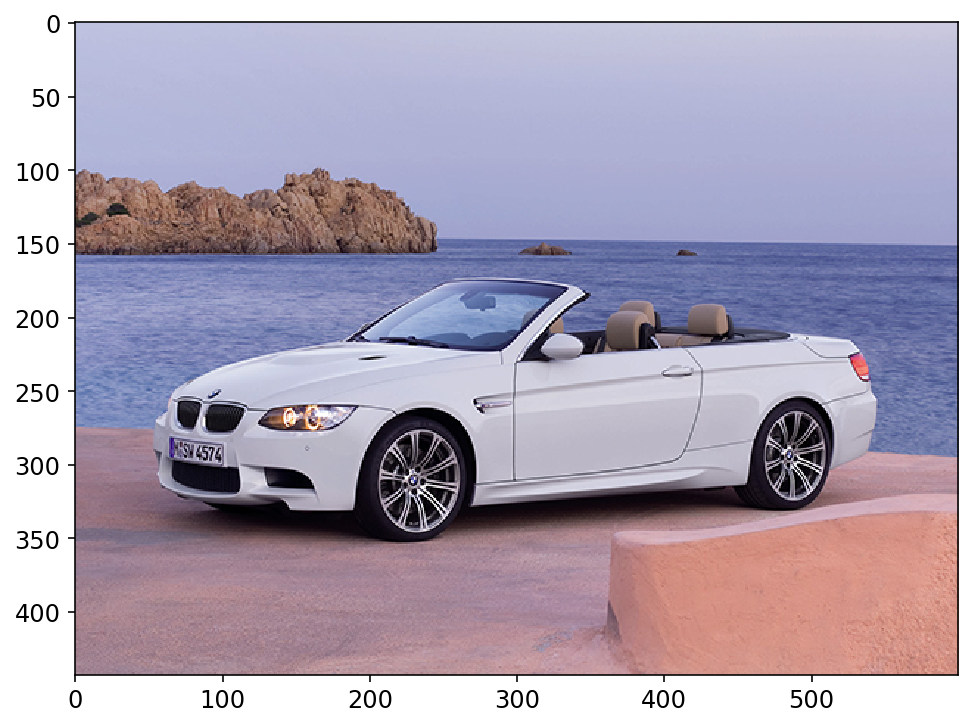

In [3]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

# visualize the image that we'll be working with
img_dir = 'images'
img_path = os.path.join(img_dir, 'bmw.png')
img = image.load_img(img_path)
plt.imshow(img)
plt.show()

In [4]:
def read_and_process_img(img_path, target_size=(224, 224)):
    """
    Reads in a single image, resize it to the specified target size
    and performs the same preprocessing on the image as the original
    pre-trained model.
    """
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)

    # keras works with batches of images, since we only have 1 image
    # here, we need to add an additional dimension to turn it into
    # shape [samples, size1, size2, channels]
    img = np.expand_dims(img, axis=0)

    # different pre-trained model preprocess the images differently
    # we also preprocess our images the same way to be consistent
    img = preprocess_input(img)
    return img

    
    
img_dir = 'images'
img_path = os.path.join(img_dir, 'bmw.png')
img = read_and_process_img(img_path)

# print a pixel's channel value
print(img[0, 0, 0])

[119.061  77.221  66.32 ]


In case your curious, the following two code cells shows what's happening underneath the hood when we call resnet50's `preprocess_input` function.

In [5]:
# the pre-trained resnet was trained on images of size 224 x 224
target_size = 224, 224
img = image.load_img(img_path, target_size=target_size)
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)

# we first transform the image's channel
# from RGB to BGR, if we look at the value
# printed below, see that the first and third
# value are reversed
print(img[0, 0, 0])
img = img[..., ::-1]
print(img[0, 0, 0])

[190. 194. 223.]
[223. 194. 190.]


In [6]:
# after that we subtract each channel
# with the overall mean (103.939 was
# the mean of the B channel across the image
# that the model was trained on) 
mean = [103.939, 116.779, 123.68]

img[..., 0] -= mean[0]
img[..., 1] -= mean[1]
img[..., 2] -= mean[2]

# hopefully, we can see that the result matches
# the preprocess_input method, note that different
# pre-trained model's preprocessing step might differ
# from one to another, it's always a good idea to
# check the source code
img[0, 0, 0]

array([119.061,  77.221,  66.32 ], dtype=float32)

Given our image, we can pass it directly to our pre-trained model's `.predict` method to generate the predicted probability of this image falling into ImageNet's 1000 class labels. After that we pass the output probability into a utility function `decode_predictions` to give us a list of ImageNet class label IDs, “human-readable” labels, and the probability associated with the labels.

In [7]:
from keras.applications.resnet50 import decode_predictions


img = read_and_process_img(img_path)
preds = model.predict(img)
print('prediction shape: ', preds.shape)
print()

preds = decode_predictions(preds, top=5)
print(preds)
print()

# hopefully, we can say that the prediction does in fact makes sense
for i, (imagenetID, label, prob) in enumerate(preds[0]):
    print('{}. {}: {:.2f}%'.format(i + 1, label, prob * 100))

prediction shape:  (1, 1000)

[[('n03100240', 'convertible', 0.954938), ('n04285008', 'sports_car', 0.037788592), ('n02974003', 'car_wheel', 0.004751421), ('n03594945', 'jeep', 0.00059314625), ('n02814533', 'beach_wagon', 0.0005832641)]]

1. convertible: 95.49%
2. sports_car: 3.78%
3. car_wheel: 0.48%
4. jeep: 0.06%
5. beach_wagon: 0.06%


Now that we've confirmed the model was able to classify our sample image pretty correctly, let's move on to the inner workings of CAM.

For our ResNet50, the `Activation`, `AveragePooling2D` (this is essentially our GAP layer), `Flatten` and `Dense` layers towards the end of the network are what we're interested in. We'll begin with the `Activation` layer. For ResNet50, this layer contains 2048 activation maps, each with dimensions $7 \times 7$. Let $f_k$ represent the $k$-th activation map, where  $k \in \{ 1, \ldots, 2048 \}$. The following `AveragePooling2D` layer reduces the size of the preceding layer to (1, 1, 2048) by taking the average of each feature map and the next `Flatten` layer merely flattens the input, without resulting in any change to the information contained in the previous GAP layer.

Our final `Dense` layer will be of size (2048, 1000), if only we look at the dominated predicted class's weights, $w_k$, then this weight is essentially connecting the $k$-th node in the `Flatten` layer to the output node corresponding to the predicted image category, which depicts the strength of each activation map for our predicted class.

The process can be summarized into the following diagram:

<img src="img/cam_process.png" width="70%" height="70%">

Or the following formula:

\begin{align}
M_c(x, y) &= \sum_k w^c_k \cdot f_k (x, y)
\end{align}

Where:

- $f_k(x, y)$ : Represents the last convolutional layer's activation for activation unit $k$ at the spatial location $x$, $y$. Spatial location here refers to the width and height location of the image.
- $w^c_k$ : Corresponds to the dense layer's weight for a given class $c$ for the activation unit $k$
- $M_c(x, y)$ : The output is the class activation map for class $c$, which indicates the importance of the activation at the spatial location $x$ and $y$ for classifying the image to class $c$.

In [8]:
from keras.models import Model


def get_resnet50_cam_info(model):
    # we need the output of the activation layer right before the
    # global average pooling (gap) layer and the last dense/softmax
    # layer that generates the class prediction
    before_gap_layer = model.layers[-4]
    class_pred_layer = model.layers[-1]

    outputs = before_gap_layer.output, class_pred_layer.output
    resnet50_cam_layers = Model(inputs=model.input, outputs=outputs)

    # only access the first element of weights, we won't be needing the bias term here
    class_weights = class_pred_layer.get_weights()[0]
    return resnet50_cam_layers, class_weights


resnet50_cam_layers, class_weights = get_resnet50_cam_info(model)
class_weights.shape

(2048, 1000)

In [9]:
from scipy.ndimage import zoom


def create_cam(img, resnet50_cam_layers, class_weights, target_size):
    # before_gap_output will be of shape [1, 7, 7, 2048] for resnet50
    before_gap_output, prediction = resnet50_cam_layers.predict(img)

    predicted_class = np.argmax(prediction)
    dominate_class_weight = class_weights[:, predicted_class]

    # the resizing parameters are hard-coded here for clarity purposes only,
    # we resize the shape of the activation so we can perform a dot product with
    # the dominated class weight, then we reshape it back to the target image size
    # so we can overlay the class activation map on top of our image later
    before_gap_output = np.squeeze(before_gap_output).reshape((-1, 2048))
    cam = np.dot(before_gap_output, dominate_class_weight).reshape((7, 7))

    # https://stackoverflow.com/questions/13242382/resampling-a-numpy-array-representing-an-image
    cam = zoom(cam, (32, 32), order=1)
    return cam
    

img = read_and_process_img(img_path)
cam = create_cam(img, resnet50_cam_layers, class_weights, target_size)
cam.shape

(224, 224)

Some quick side note regarding the `zoom` function. When performing various transformations on our image, we often need to employ some sort of interpolation in order to obtain a good image quality after the transformation, e.g. after rotation, we found out that a pixel should have the same color as pixel (3.4, 5.6) in the original image. The only problem is that there is no such thing as fractional pixels, thus we need to find a way to impute these values.

For scipy's `zoom` function, we can specify different interpolation techniques.

- Nearest is `order=0`. This is the interpolation that requires the least processing time of all the interpolation algorithms because it only considers one pixel, the closest one to the interpolated point. This has the effect of making each pixel bigger.
- Bilinear interpolation would be `order=1`. Bilinear interpolation considers the closest $2 \times 2$ neighborhood of known pixel values surrounding the unknown pixel. It then takes a weighted average of these 4 pixels to arrive at its final interpolated value. This results in much smoother looking images than nearest neighbor.
- Bicubic is the default (`order=3`). Bicubic goes one step beyond bilinear by considering the closest $4 \times 4$ neighborhood of known pixels, a total of 16 pixels. Since these are at various distances from the unknown pixel, closer pixels are given a higher weighting in the calculation. Bicubic produces noticeably sharper images than the previous two methods, and is perhaps the ideal combination of processing time (there're higher order available, but as we can image they are often times expensive to compute and can have diminishing returns) and output quality. For this reason it is a standard in many image editing programs (including Adobe Photoshop), printer drivers and in-camera interpolation.

The following code uses OpenCV to load image, convert it from BGR format to RGB as the default channel ordering for OpenCV is BGR, and resizes the image to $224 \times 224$. After that we plot the image and overlay our class activation map over the original image.

OpenCV is often preferred when we're doing a lot of image manipulation and speed is a huge concern (It is often times faster than the PIL library, which is what is used underneath the hood of keras' image preprocessing function). OpenCV is a huge topic by itself and there are various links floating around the web to if you wish to dig deeper. e.g. [Blog: Basic Image Manipulations in Python and OpenCV: Resizing (scaling), Rotating, and Cropping](https://www.pyimagesearch.com/2014/01/20/basic-image-manipulations-in-python-and-opencv-resizing-scaling-rotating-and-cropping/)

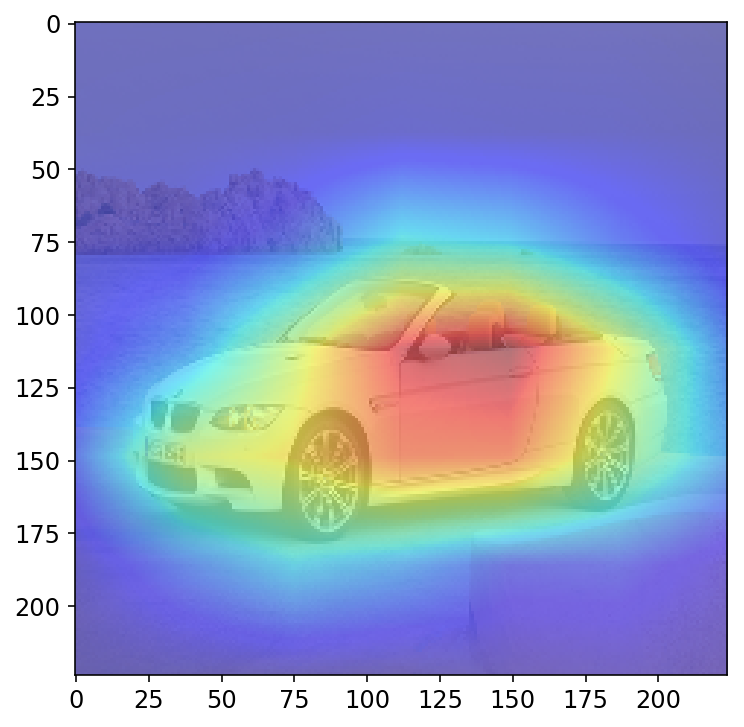

In [10]:
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, target_size)

# we can achieve the same thing here without using opencv,
# it was merely used to ensure we know about the tool's existence
# img = image.load_img(img_path, target_size=target_size)

fig, ax = plt.subplots()
ax.imshow(img, alpha=0.5)
ax.imshow(cam, cmap='jet', alpha=0.5)

plt.show()

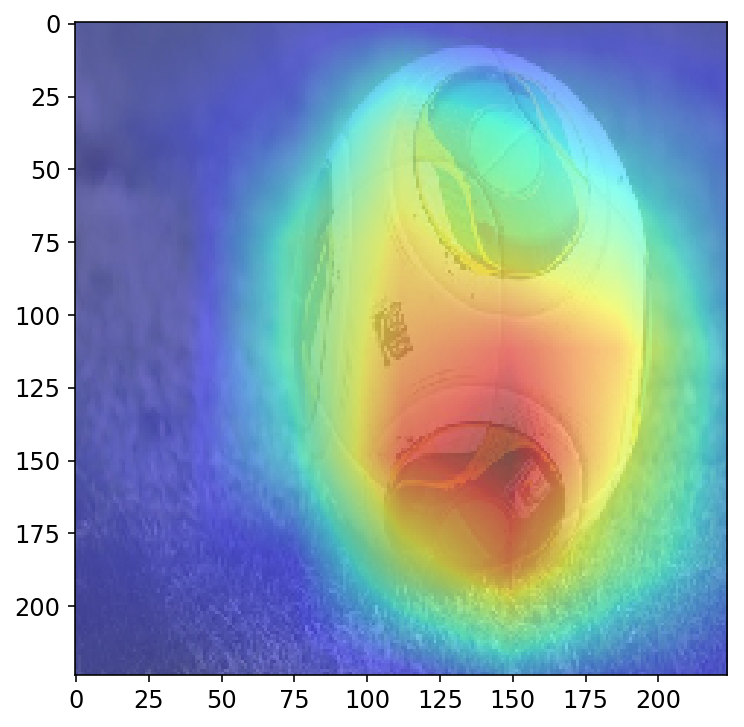

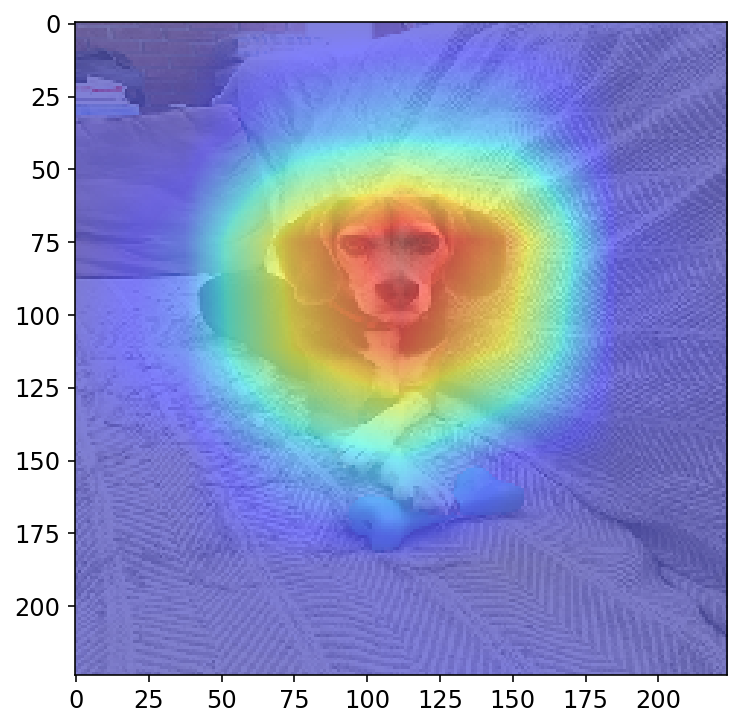

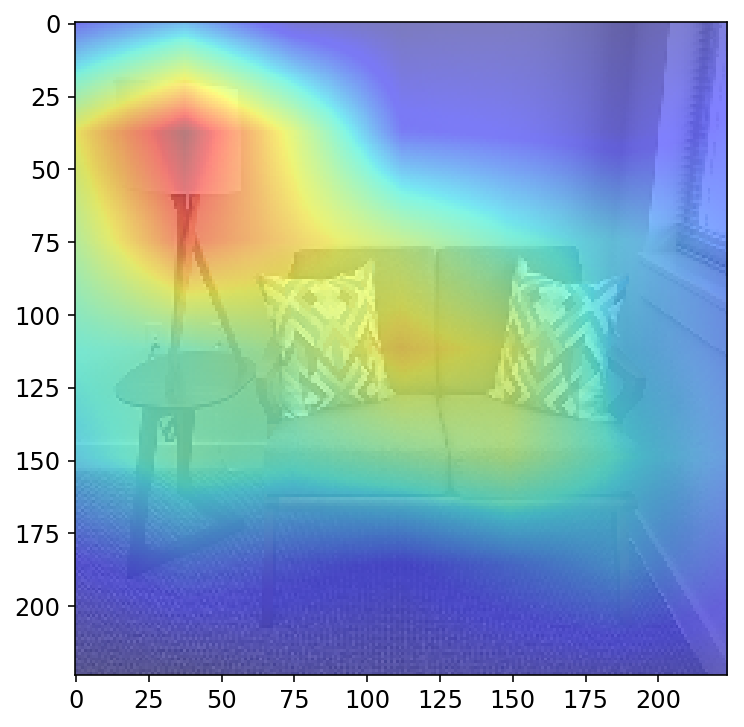

In [19]:
from explainer import CAMExplainer

cam_explainer = CAMExplainer(model, target_size)

img_files = ['soccer_ball.jpg', 'jemma.png', 'office.png']
for img_file in img_files:  
    img_path = os.path.join(img_dir, img_file)
    cam_explainer.fit(img_path).plot()

# Reference

- [Blog: ImageNet: VGGNet, ResNet, Inception, and Xception with Keras](http://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/)
- [Github: Keras Applications](https://github.com/keras-team/keras-applications)
- [Jupyter Notebook: Residual Networks](http://nbviewer.jupyter.org/github/Kulbear/deep-learning-coursera/blob/master/Convolutional%20Neural%20Networks/Residual%20Networks%20-%20v1.ipynb)

- [Youtube: Why ResNets Work](https://www.youtube.com/watch?v=RYth6EbBUqM&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=15)
- [Blog: Decoding the ResNet architecture](http://teleported.in/posts/decoding-resnet-architecture/)
- [Paper: K. He, X. Zhang, S. Ren, J. Sun - Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
- [Github: ResNetCAM-keras](https://github.com/alexisbcook/ResNetCAM-keras)
- [Blog: Global Average Pooling Layers for Object Localization](https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/)
- [Paper: B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, A. Torralba - Learning Deep Features for Discriminative Localization (2015)](https://arxiv.org/abs/1512.04150)
- [Blog: Coding Bilinear Interpolation](http://supercomputingblog.com/graphics/coding-bilinear-interpolation/)
- [Blog: Digital Image Interpolation](https://www.cambridgeincolour.com/tutorials/image-interpolation.htm)